# BIAS CORRECTION OF DECADAL PREDICTIONS: Application to the ensemble of predictions

## Tools for accessing and processing climate data: Case study with R


------------

This worked example uses R packages from the  climate4R framework, see the article ["climate4R: An R-based Framework for Climate Data Access, Post-processing and Bias Correction"](https://www.sciencedirect.com/science/article/pii/S1364815218303049).

## Table of Contents

* [Parameter Setting](#parameter-setting)
* [1. Library Loading](#1--library-loading)
* [2. Definition of Geographical Boundaries](#definition-of-geographical-boundaries)
* [3. Data Loading and Basic Visualization](#data-loading-and-basic-visualization)
    * [3.1. Data loading of the observational reference](#data-loading-of-the-observational-reference)
    * [3.2. Data loading of decadal predictions and cration of the Multi-member ensemble of 10 lead-years](#data-loading-of-decadal-predictions-and-cration-of-the-multi-member-ensemble-of-10-lead-years)
    * [3.3. Basic Data Visualization](#basic-data-visualization)
* [4. Bias correction of the multi-member ensemble](#bias-correction-of-the-multi-member-ensemble)
* [7. Export the Results](#export-the-results)

In [1]:
options(java.parameters = "-Xmx8g")

-----

## Parameter setting

Here you can set a few parameters to change the notebook behaviour

### General parameters

In [2]:
# Select city from the following options: "Barcelona", "Bergen", "Paris", "Prague".
city <- "Paris" 
# Select the variable and specify the initialization year for the decadal prediction, ensuring it falls within the observational period range
variable <- "tas"
# Specify the factor with which to upscale the observational grid
obs.upscaling.factor <- 4
# Specify the path to the folder containing the data
data.dir <- "../data"
output.dir <- "../results_bc_ensemble"

### Bias correction parameters

Change or keep or add or remove parameters within the following list. Go to the help page of the `biasCorrection` function (by running `help(biascorrection)`) for further parametrization options and documentation.

In [3]:
bc.args <- list(
    # Bias correction method. Options are: "delta", "scaling", "eqm", "pqm", "gpqm", "loci", "dqm", "qdm", "isimip3"
    method = "eqm",
    # Scaling type (only used for method = "scaling")
    scaling.type = "additive",  # or "multiplicative"
    # Moving window width used to calibrate and the target days
    window = c(30, 30),
    # Arguments used if the method is parametric (i.e. method = "pqm")
    fitdistr.args = list(densfun = "normal"),
    # Set the precipitation parameter as TRUE if the variable being corrected is precipitation, and change the default wet threshold if desired.
    precipitation = FALSE,
    wet.threshold = 1,
    # Define the following parameters to apply the bias correction funtion in cross-validation mode
    cross.val = "none", # or "loo", or "kfold"
    folds = NULL, # or the list of year-periods defining the folds
    # Extrapolation 
    extrapolation = "constant", # or "none"
    join.members = TRUE
)

---------------
-----

## 1. Library loading

In [4]:
library(loadeR)
library(loadeR.2nc)
library(transformeR)
library(visualizeR)
library(downscaleR)
library(magrittr)
library(geoprocessoR)
library(sp)
library(repr)
options(repr.plot.width=10, repr.plot.height=4)

Loading required package: rJava

Loading required package: loadeR.java

Java version 22x amd64 by N/A detected

NetCDF Java Library v4.6.0-SNAPSHOT (23 Apr 2015) loaded and ready

Loading required package: climate4R.UDG

climate4R.UDG version 0.2.6 (2023-06-26) is loaded

Please use 'citation("climate4R.UDG")' to cite this package.

loadeR version 1.8.1 (2023-06-22) is loaded

Please use 'citation("loadeR")' to cite this package.




    _______   ____  ___________________  __  ________ 
   / ___/ /  / /  |/  / __  /_  __/ __/ / / / / __  / 
  / /  / /  / / /|_/ / /_/ / / / / __/ / /_/ / /_/_/  
 / /__/ /__/ / /  / / __  / / / / /__ /___  / / \ \ 
 \___/____/_/_/  /_/_/ /_/ /_/  \___/    /_/\/   \_\ 
 
      github.com/SantanderMetGroup/climate4R



transformeR version 2.2.2 (2023-10-26) is loaded

Please see 'citation("transformeR")' to cite this package.

visualizeR version 1.6.4 (2023-10-26) is loaded

Please see 'citation("visualizeR")' to cite this package.

downscaleR version 3.3.4 (2023-06-22) is loaded

Please use 'citation("downscaleR")' to cite this package.

Please note that rgdal will be retired during October 2023,
plan transition to sf/stars/terra functions using GDAL and PROJ
at your earliest convenience.
See https://r-spatial.org/r/2023/05/15/evolution4.html and https://github.com/r-spatial/evolution
rgdal: version: 1.6-7, (SVN revision 1203)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 3.8.5, released 2024/04/02
Path to GDAL shared files: /opt/conda/envs/climate4r/share/gdal
 GDAL does not use iconv for recoding strings.
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 9.4.0, March 1st, 2024, [PJ_VERSION: 940]
Path to PROJ shared files: /home/jovyan/

## 2. Initial setups

Definition of the geographical boundaries of each demonstrator:

In [5]:
domain <- switch(city,
  Barcelona = list(latLim = c(39, 44), lonLim = c(-1, 4)),
  Bergen = list(latLim = c(58, 63), lonLim = c(4, 9)),
  Paris = list(latLim = c(46.5, 51.5), lonLim = c(-1, 4.5)),
  Prague = list(latLim = c(47.5, 52.5), lonLim = c(12, 17))
)
city.centre <- switch(city,
  Barcelona = data.frame(x = 2.2, y = 41.4),
  Bergen = data.frame(x = 5.3, y = 60.4),
  Paris = data.frame(x = 2.3, y = 48.8),
  Prague = data.frame(x = 14.4, y = 50.1)
)

Definition of the base name used to save the intermediate R data objects and to write the final NetCDF files:

In [6]:
base.filename <- paste0(output.dir, "/", c(city, variable, bc.args$method) %>% paste(collapse = "_")) %>% print

[1] "../results_bc_ensemble/Paris_tas_eqm"


## 3. Data loading and basic visualization

Datasets (NcML files) of the decadal predictions:

In [7]:
ncml.dir <- "../data/ncml/EC-Earth3/dcppA-hindcast/"
datasets <- list.files(ncml.dir, full.names = T) 
datasets %>% head

[1] "../data/ncml/EC-Earth3/dcppA-hindcast//s1960-r1i4p1f1_day_tas_gr_v20220322.ncml"
[2] "../data/ncml/EC-Earth3/dcppA-hindcast//s1961-r1i4p1f1_day_tas_gr_v20220322.ncml"
[3] "../data/ncml/EC-Earth3/dcppA-hindcast//s1962-r1i4p1f1_day_tas_gr_v20220322.ncml"
[4] "../data/ncml/EC-Earth3/dcppA-hindcast//s1963-r1i4p1f1_day_tas_gr_v20220322.ncml"
[5] "../data/ncml/EC-Earth3/dcppA-hindcast//s1964-r1i4p1f1_day_tas_gr_v20220322.ncml"
[6] "../data/ncml/EC-Earth3/dcppA-hindcast//s1965-r1i4p1f1_day_tas_gr_v20220322.ncml"

We discard initializations before 1974 because the lack of observational data before 1984.

In [8]:
datasets <- datasets[(datasets %>% grep(pattern = "1974")) : length(datasets)] %<>% print

 [1] "../data/ncml/EC-Earth3/dcppA-hindcast//s1974-r1i4p1f1_day_tas_gr_v20220322.ncml"
 [2] "../data/ncml/EC-Earth3/dcppA-hindcast//s1975-r1i4p1f1_day_tas_gr_v20220322.ncml"
 [3] "../data/ncml/EC-Earth3/dcppA-hindcast//s1976-r1i4p1f1_day_tas_gr_v20220322.ncml"
 [4] "../data/ncml/EC-Earth3/dcppA-hindcast//s1977-r1i4p1f1_day_tas_gr_v20220322.ncml"
 [5] "../data/ncml/EC-Earth3/dcppA-hindcast//s1978-r1i4p1f1_day_tas_gr_v20220322.ncml"
 [6] "../data/ncml/EC-Earth3/dcppA-hindcast//s1979-r1i4p1f1_day_tas_gr_v20220322.ncml"
 [7] "../data/ncml/EC-Earth3/dcppA-hindcast//s1980-r1i4p1f1_day_tas_gr_v20220322.ncml"
 [8] "../data/ncml/EC-Earth3/dcppA-hindcast//s1981-r1i4p1f1_day_tas_gr_v20220322.ncml"
 [9] "../data/ncml/EC-Earth3/dcppA-hindcast//s1982-r1i4p1f1_day_tas_gr_v20220322.ncml"
[10] "../data/ncml/EC-Earth3/dcppA-hindcast//s1983-r1i4p1f1_day_tas_gr_v20220322.ncml"
[11] "../data/ncml/EC-Earth3/dcppA-hindcast//s1984-r1i4p1f1_day_tas_gr_v20220322.ncml"
[12] "../data/ncml/EC-Earth3/dcppA-hindcast

Dataset (NcML file) of the observational reference:

In [9]:
ncml.dir.obs <- "../data/ncml/CERRA/"
dataset.obs <- list.files(ncml.dir.obs, full.names = T) 
dataset.obs

[1] "../data/ncml/CERRA//tas_f3h-r2631x1113.ncml"

### 3.1. Data loading of the observational reference


The observational reference grid is high resolution, therefore, it is a common practice to perform an upscaling in order to avoid a big resolution mismatch. For eficiency, here  data loading is performed year by year and upscaled in each iteration. This operation takes a few minutes.

In [10]:
if (!file.exists(paste0(base.filename, "_city.obs.rda"))) {
    
    city.obs <- lapply(1984:2004, function(y) {
        message("Loading and upscaling year...", y)
        loadGridData(dataset.obs, 
                     var = variable, 
                     latLim = domain$latLim,
                     lonLim = domain$lonLim, 
                     years = y) %>%
        upscaleGrid(times = obs.upscaling.factor, aggr.fun = list(FUN = "mean", na.rm = T)) %>%
        redim(drop = TRUE) %>% suppressMessages
    })

    saveRDS(city.obs, paste0(base.filename, "_city.obs.rda"))

} else {

    city.obs <- readRDS(paste0(base.filename, "_city.obs.rda"))
    
}

As the data loading has been performed in a loop of years, the next step is to obtain a single grid from the loaded list of grids, binding them over the time dimension.

In [11]:
city.obs <- bindGrid(city.obs, dimension = "time")

### 3.2. Data loading of decadal predictions and cration of the Multi-member ensemble of 10 lead-years

A lead-year is loaded in each iteration (`m`). For each lead-year the code iterates over each dataset, where the first year `y` is extracted from the dataset information, and where two loading operations are performed. In the first step, the November and December are loaded from the first year of the corresponding lead-year (`y + m`). In the second step, the subsequent year is loaded (`y + m + 1`) from January to October. The binding of both grids is performed afterward. 

In [12]:
if (!file.exists(paste0(base.filename, "_city.pred.m.rda"))) {
    
    city.pred.m <- lapply(0:9, function(m) {
        message("loading lead-year: ", m)
        lapply(datasets, function(d) {
            di <- dataInventory(d) %>% suppressMessages
            y <- di$tas$Dimensions$time$Date_range %>%  substring(first = 1, last = 4) %>% as.numeric 
            g1 <- loadGridData(d, 
                               years = y + m, 
                               season = 11:12,
                               var = variable,  
                               latLim = domain$latLim,
                               lonLim = domain$lonLim) %>% suppressMessages
            g2 <- loadGridData(d, 
                               years = y + m + 1, 
                               season = 1:10,
                               var = variable,  
                               latLim = domain$latLim,
                               lonLim = domain$lonLim) %>% suppressMessages
            bindGrid(g1, g2, dimension = "time") 
        }) %>% c(dimension = "time") %>% do.call(what = "bindGrid")
    })

    saveRDS(city.pred.m, paste0(base.filename, "_city.pred.m.rda"))

} else {

    city.pred.m <- readRDS(paste0(base.filename, "_city.pred.m.rda"))

}

Quick look at the time series to illustrate the overlapping and non-overlapint time periods:

pad applied on the interval: day

pad applied on the interval: day



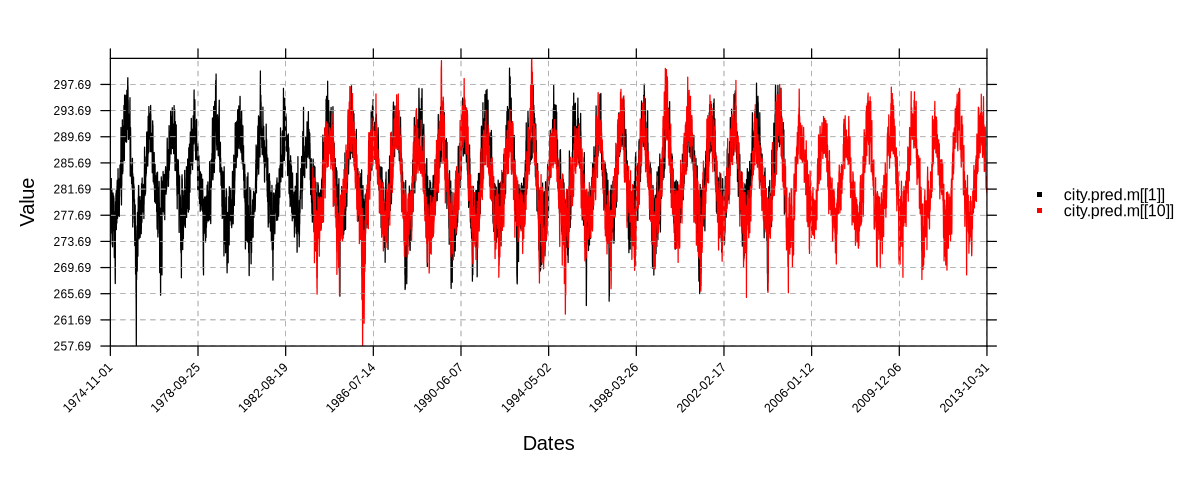

In [13]:
temporalPlot(city.pred.m[[1]], city.pred.m[[10]])

Temporal intersection of the 10 members:

In [14]:
city.pred.m.common <- intersectGrid(city.pred.m[[1]], city.pred.m[[2]], city.pred.m[[3]], city.pred.m[[4]], city.pred.m[[5]], 
                   city.pred.m[[6]], city.pred.m[[7]], city.pred.m[[8]], city.pred.m[[9]], city.pred.m[[10]], 
                   type = "temporal", 
                   which.return = 1:10)

Bind all lead-years over the "member" dimension to create a multi-member grid:

In [15]:
city.pred.ens <- bindGrid(city.pred.m.common, dimension = "member")

The `temporalPlot` function recognizes the member dimension and plots the ensemble mean time series (solid line) and the spread (shadow): 

pad applied on the interval: day



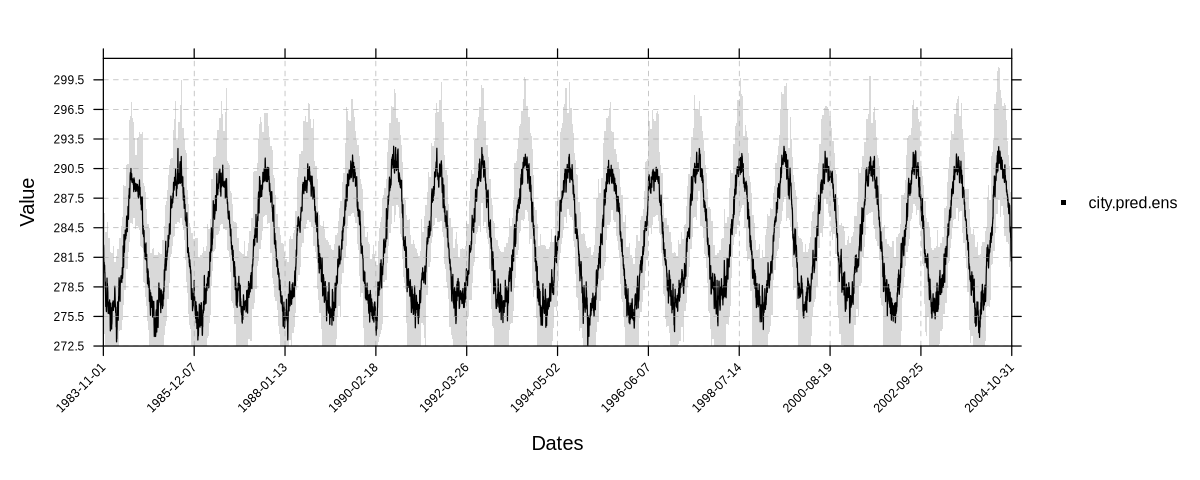

In [16]:
temporalPlot(city.pred.ens)

## 4. Bias correction of the multi-member ensemble 

Temporal intersection of the observation and the prediction:

In [17]:
city.obs <- intersectGrid(city.obs, city.pred.ens, which.return = 1)
city.pred.ens <- intersectGrid(city.obs, city.pred.ens, which.return = 2)

The `biasCorrection` function uses the nearest prediction grid-point to each observational grid-point for correcting the bias. Next, an example of an application is illustrated, where the joint distribution of all members is considered for bias correction. 

```R
cal.ens <- biasCorrection(y = city.obs, 
                              x = city.pred.ens, 
                              newdata = city.pred.ens, 
                              method = "eqm",
                              join.members = TRUE)
```

In order to apply the `biasCorrection` function using the parameters set at the beginning of this notebook, define the `x` and `y` slots of the parameter list assigning them the loaded grids. Then the `do.call` function is used.  

In [18]:
bc.args[["y"]] <- city.obs
bc.args[["x"]] <- city.pred.ens

In [19]:
if (!file.exists(paste0(base.filename, "_cal.ens.rda"))) {
    
    cal.ens <- do.call("biasCorrection", bc.args)

    saveRDS(cal.ens, paste0(base.filename, "_cal.ens.rda"))
    
} else {

    cal.ens <- readRDS(paste0(base.filename, "_cal.ens.rda"))

}

In [20]:
cal.ens$Dates <- lapply(cal.ens$Dates, as.character)

The `window` option is currently not supported for joined members. To use the window option set `join.members = FALSE` (see the example below). 

Optional saving of the resulting object to save time in the future:

Daily time series:

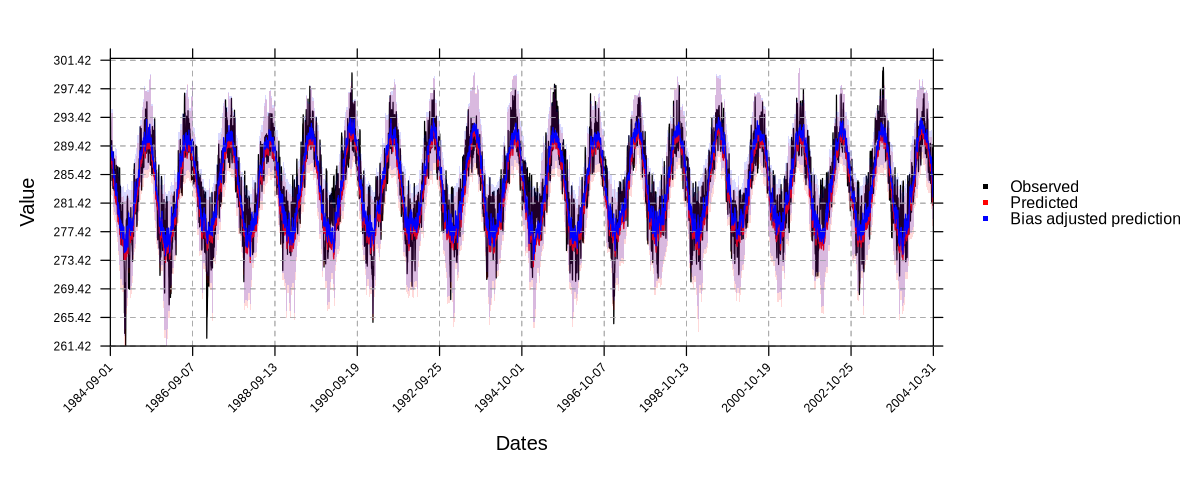

In [22]:
temporalPlot("Observed" = city.obs, 
             "Predicted" = city.pred.ens,  
             "Bias adjusted prediction" = cal.ens) %>% suppressMessages

Annual time series:

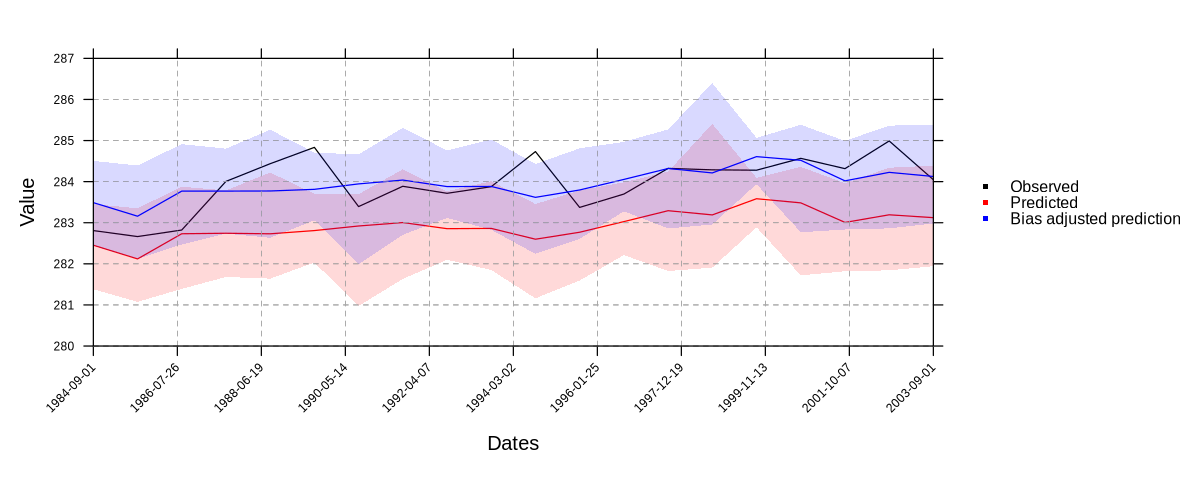

In [24]:
temporalPlot("Observed" = city.obs %>% aggregateGrid(aggr.y = list(FUN = mean, na.rm = TRUE)), 
             "Predicted" = city.pred.ens %>% aggregateGrid(aggr.y = list(FUN = mean, na.rm = TRUE)),
             "Bias adjusted prediction" = cal.ens %>% aggregateGrid(aggr.y = list(FUN = mean, na.rm = TRUE)),
             xyplot.custom = list(ylim = c(280, 287))) %>% suppressMessages

Bias correction of each member separately and using the moving window option:

In [25]:
bc.args[["join.members"]] <- FALSE %>% print
bc.args[["window"]] %>% print

[1] FALSE
[1] 30 30


In [26]:
if (!file.exists(paste0(base.filename, "_cal.ens.2.rda"))) {
    
    cal.ens.2 <- do.call("biasCorrection", bc.args)

    saveRDS(cal.ens.2, paste0(base.filename, "_cal.ens.2.rda"))
    
} else {

    cal.ens.2 <- readRDS(paste0(base.filename, "_cal.ens.2.rda"))

}

[2024-05-07 16:55:14.386855] Trying to determine the time zone...

[2024-05-07 16:55:14.389095] Time zone identified and set to GMT
See 'setGridDates.asPOSIXlt' to change the time zone

[2024-05-07 16:55:15.221455] Already complete date record. Nothing was done

[2024-05-07 16:55:15.283503] Trying to determine the time zone...

[2024-05-07 16:55:15.2854] Time zone identified and set to GMT
See 'setGridDates.asPOSIXlt' to change the time zone

[2024-05-07 16:55:16.618222] Already complete date record. Nothing was done

[2024-05-07 16:55:16.685257] Trying to determine the time zone...

[2024-05-07 16:55:16.687144] Time zone identified and set to GMT
See 'setGridDates.asPOSIXlt' to change the time zone

[2024-05-07 16:55:17.242851] Already complete date record. Nothing was done

[2024-05-07 16:55:31.121112] Argument precipitation is set as FALSE, please ensure that this matches your data.

[2024-05-07 16:55:40.907812] Number of windows considered: 12...

[2024-05-07 16:55:41.194015] Bias-

In [27]:
cal.ens.2$Dates <- lapply(cal.ens.2$Dates, as.character)

Annual time series:

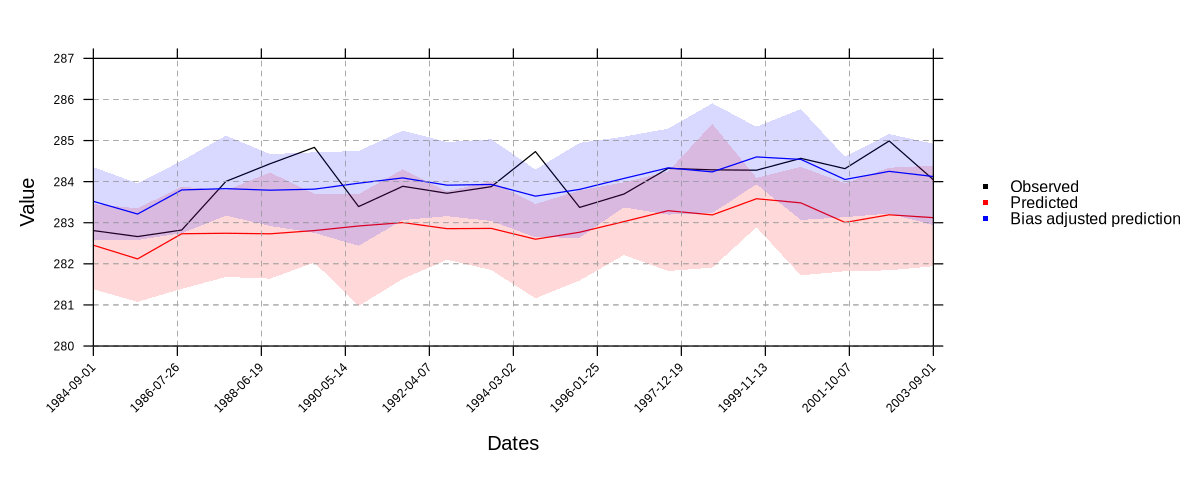

In [28]:
temporalPlot("Observed" = city.obs %>% aggregateGrid(aggr.y = list(FUN = mean, na.rm = TRUE)), 
             "Predicted" = city.pred.ens %>% aggregateGrid(aggr.y = list(FUN = mean, na.rm = TRUE)),
             "Bias adjusted prediction" = cal.ens.2 %>% aggregateGrid(aggr.y = list(FUN = mean, na.rm = TRUE)),
             xyplot.custom = list(ylim = c(280, 287))) %>% suppressMessages

## 7. Export the Results

In [29]:
grid2nc(cal.ens, NetCDFOutFile = paste0(base.filename, "_joint-members.nc"))
grid2nc(cal.ens.2, NetCDFOutFile = paste0(base.filename, "_separated-members.nc"))

[2024-05-07 17:02:15.918719] NetCDF file written in: ../results_bc_ensemble/Paris_tas_eqm_joint-members.nc

[2024-05-07 17:02:27.864494] NetCDF file written in: ../results_bc_ensemble/Paris_tas_eqm_separated-members.nc

